In [1]:
import sys, os
sys.path.append(os.pardir)

os.environ["KERAS_BACKEND"]='tensorflow'
#import glob
import numpy as np


#from multiprocessing import Pool
#import multiprocessing as multi
#from data.func import load_npy, padding_mat
#sys.path.append('C:\\ProgramData\\Anaconda3\\pkgs\\pydot-1.2.3-py36hd4f83f9_0\\Lib\\site-packages')
#sys.path
x_train = np.load('/home/owner/デスクトップ/PythonFile/imdb/x_train_sort.npy')
x_test = np.load('/home/owner/デスクトップ/PythonFile/imdb/x_test_sort.npy')
y_train = np.load('/home/owner/デスクトップ/PythonFile/imdb/t_train.npy')
y_test = np.load('/home/owner/デスクトップ/PythonFile/imdb/t_test.npy')

embWeights=np.load('/home/owner/デスクトップ/PythonFile/imdb/weights.npy')
idx=np.load('/home/owner/デスクトップ/PythonFile/imdb/index.npy')
embWeights = embWeights[idx]

print('data loaded')

##

import keras
from keras.layers import Input, merge
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import Embedding
from keras.layers import LSTM
import keras.backend as K
from keras.layers import Lambda, regularizers, Average

from keras.models import Model
from keras.layers import Input, Conv2D, Conv1D, MaxPooling2D, GlobalMaxPooling2D, GlobalMaxPooling1D, MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import GRU
from keras.layers.wrappers import Bidirectional, TimeDistributed
from keras.layers.core import Dropout, Dense, Lambda, Masking
from keras.layers import merge, Layer, Activation, Dot, Concatenate, Flatten, Lambda

from keras.initializers import Identity,glorot_normal
from keras import regularizers

from keras import metrics

from keras.utils import plot_model



numSentencesPerDoc, numWordsPerSentence = x_train[0].shape[0], x_train[0].shape[1]
print(numSentencesPerDoc, numWordsPerSentence)
#print(x_train[0])

vocabSize, embeddingSize = embWeights.shape[0], embWeights.shape[1]
print(vocabSize, embeddingSize)

dropWordEmb = 0.25
recursiveClass = GRU

filters = 1 #embeddingSize*2
windowMin = 3
windowMax = 7
# dimOfSentimentMetrics = 5
batch_size = 256
epochs = 25
numGRU = 100
numDensePool=50
eta = 1e-5
dr = 0.5

##

#wordsInputs = Input(shape=(numWordsPerSentence,1), batch_shape=(numSentencesPerDoc,numWordsPerSentence,), dtype='int32', name='words_input')

x_in = Input( shape = ( numSentencesPerDoc, numWordsPerSentence ) , name='Input' )
#x_pop = Lambda( lambda x: x, output_shape=(numWordsPerSentence, ) , name='convert_shape' )( x_in )
    
#Layer functionの定義
embLayer = Embedding( input_dim=embWeights.shape[0], output_dim=embWeights.shape[1], weights=[embWeights]
                      ,mask_zero=True , trainable=True, embeddings_regularizer=regularizers.l2(0.0000001)
                      , input_length=numWordsPerSentence, name='Embedding' )


maxPooledPerDoc = []
convNets = []
maxPools = []

extraDimLayer = Lambda(lambda x: K.expand_dims(x), name='extraDimForConvo')
squeezeThirdLayer = Lambda(lambda x: K.squeeze(x, 3), name='squeezeThirdLayer')

for windowSize in range(windowMin,windowMax):
    name='word_mat_convo_win_size_'+str(windowSize)
    convNet = Conv2D(filters, kernel_size=(windowSize,embeddingSize), padding='valid', activation='relu'
                     ,strides=1, use_bias=True, input_shape=(numWordsPerSentence, embeddingSize, 1), data_format="channels_last",kernel_initializer=glorot_normal()
                     ,bias_regularizer=regularizers.l2(eta), kernel_regularizer=regularizers.l2(eta),name=name)
    convNets.append(convNet)
    name='word_mat_max_pool_win_size_'+str(windowSize)
    maxPool = MaxPooling1D(pool_size = int(numWordsPerSentence-windowSize-1), padding='valid')
    maxPools.append(maxPool)
    
    
for i in range(numSentencesPerDoc):
    maxPooledPerSentence = []
    x_pop = Lambda(lambda x: x[:,i], output_shape=(numWordsPerSentence, ) , name='convert_shape_'+'sentence'+str(i+1))( x_in )

    for j in range(windowMax-windowMin):   
        emb = embLayer(x_pop)
        emb = Dropout(dr,name='DropEmb'+str(i)+str(j))(emb)
        reshaped = extraDimLayer(emb)#Lambda(lambda x: K.expand_dims(x), name='extraDimForConvo_'+str(j)+'_sentence_'+str(i))(emb)
        name='word_mat_convo_win_size_'+str(j)+'_sentence_'+str(i)
        # wordsCNN = Conv2D(filters, kernel_size=(windowSize,embeddingSize), padding='valid', 
        #                    activation='relu', strides=1, use_bias=True, input_shape=(numWordsPerSentence, embeddingSize, 1), data_format="channels_last",
        #                    kernel_initializer=glorot_normal(),kernel_regularizer=regularizers.l2(),name=name)(reshaped)
        wordsCNN  = convNets[j](reshaped)
        wordsCNN = Dropout(dr,name='DropCNN'+str(i)+str(j))(wordsCNN)
        squeezed = squeezeThirdLayer(wordsCNN)#Lambda(lambda x: K.squeeze(x, 3), name='squeezeThirdLayer_'+str(j)+'_sentence_'+str(i))(wordsCNN)
        # newShape = (-1, int(squeezed.shape[1])*int(squeezed.shape[2]))
        # squeezed = Lambda(lambda x: K.reshape(x,shape=newShape), name ='squeezeDimForMaxPool'+str(i)+str(j))(squeezed)
        wordsCNNPooled=GlobalMaxPooling1D()(squeezed)
        #wordsCNNPooled= MaxPooling1D(pool_size = int(squeezed.shape[1]), padding='valid')(squeezed)
        maxPooledPerSentence.append(wordsCNNPooled)
        
    mergedPoolForSentence = Concatenate(axis = 1)(maxPooledPerSentence)
    newShape=(-1,1,int(mergedPoolForSentence.shape[1]))
    reshapedPoolForSentence = Lambda(lambda x: K.reshape(x,shape=newShape), name ='switch_axis_'+'sentence'+str(i+1)+'winSize'+str(j+windowMin))(mergedPoolForSentence)
    densePoolForSentence = Dense(numDensePool, bias_regularizer=regularizers.l2(eta),
                                 kernel_regularizer=regularizers.l2(eta), activation='softmax', use_bias=True)(reshapedPoolForSentence)

    densePoolForSentence = Dropout(dr,name='DropDense'+str(i))(densePoolForSentence)
    maxPooledPerDoc.append(densePoolForSentence)
    
#Naive Approach
averaged = Average()(maxPooledPerDoc) 
averaged = Lambda(lambda x:K.reshape(x,shape=(-1,int(averaged.shape[1])*int(averaged.shape[2]))), name ='attend_output')(averaged)
out_avg = Dense(1, activation='sigmoid', use_bias=True)(averaged) 
    
#Apply Attention 
mergedPoolPerDoc = Concatenate(axis = 1)(maxPooledPerDoc)
biRnn_ = Bidirectional(GRU(int(mergedPoolPerDoc.shape[2]),  return_sequences=True, bias_regularizer=regularizers.l2(eta)
                           ,kernel_regularizer=regularizers.l2(eta),recurrent_regularizer=regularizers.l2(eta)
                           ,dropout=dr, recurrent_dropout=dr, unroll=True), merge_mode='concat')(mergedPoolPerDoc)
newShape = (-1, int(mergedPoolPerDoc.shape[1]), 2*int(mergedPoolPerDoc.shape[2]))
biRnn = Lambda(lambda x: K.reshape(x,shape=newShape), name ='biRnn_TF_Reminder')(biRnn_)

CONTEXT_DIM = 100#int(int(biRnn.shape[1])*int(biRnn.shape[2])/2) 

eij = Dense(CONTEXT_DIM, kernel_regularizer=regularizers.l2(eta), bias_regularizer=regularizers.l2(eta)
            , use_bias=True, activation='tanh')(biRnn)
eij = Dense(CONTEXT_DIM, kernel_regularizer=regularizers.l2(eta), use_bias=False, activation='softmax')(eij)

weighted_input_ = Dot(axes = 1)([eij, biRnn])
weighted_input = Lambda(lambda x: K.reshape(x,shape=(-1,int(weighted_input_.shape[1])*int(weighted_input_.shape[2]))), name ='attend_output')(weighted_input_)

out = Dense(1, kernel_regularizer=regularizers.l2(eta), bias_regularizer=regularizers.l2(eta)
            , activation='sigmoid', use_bias=True)(weighted_input)




##

model = Model(input=[x_in], output=[out])
# adadelta = keras.optimizers.Adadelta(lr=0.5, rho=0.95, epsilon=None, decay=0.0)
# model.compile(loss='binary_crossentropy',
#               optimizer=adadelta,
#               metrics=['accuracy'])
         
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
              metrics=['accuracy'])

print("Attention Model Build Complete")
##
model_avg = Model(inputs=[x_in], outputs=[out_avg])
model_avg.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
              metrics=['accuracy'])

print("Average Model Build Complete")
##
#save model to png file
from keras.utils import plot_model
plot_model( model, to_file='model.png' )

#モデルを保存せず直接可視化
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG( model_to_dot( model ).create( prog='dot', format='svg' ) )
'''
##
print('Train...')
history = model.fit(x_train, y_train, batch_size = batch_size, verbose=1, epochs=epochs
                    ,validation_split=0.2, shuffle=True)
'''
                    
                    
                    

data loaded


Using TensorFlow backend.
/home/owner/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


10 50
52306 300


/home/owner/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:166: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


Attention Model Build Complete
Average Model Build Complete


"\n##\nprint('Train...')\nhistory = model.fit(x_train, y_train, batch_size = batch_size, verbose=1, epochs=epochs\n                    ,validation_split=0.2, shuffle=True)\n"

In [2]:
save_model = keras.callbacks.ModelCheckpoint('./params.hdf5', monitor='val_loss', verbose=1
                                             , save_best_only=True, save_weights_only=True, mode='min', period=1)

In [3]:
history = model_avg.fit(x_train, y_train, batch_size = batch_size, verbose=1, epochs=300 #epochs
                        ,validation_split=0.2, shuffle=True, callbacks=[save_model])

Train on 19852 samples, validate on 4964 samples
Epoch 1/300
19852/19852 [==============================] - 18s 911us/step - loss: 0.7452 - acc: 0.5008 - val_loss: 0.7446 - val_acc: 0.4950

Epoch 00001: val_loss improved from inf to 0.74463, saving model to ./params.hdf5
Epoch 2/300
19852/19852 [==============================] - 13s 656us/step - loss: 0.7435 - acc: 0.5008 - val_loss: 0.7428 - val_acc: 0.4950

Epoch 00002: val_loss improved from 0.74463 to 0.74281, saving model to ./params.hdf5
Epoch 3/300
19852/19852 [==============================] - 13s 660us/step - loss: 0.7416 - acc: 0.5008 - val_loss: 0.7409 - val_acc: 0.4950

Epoch 00003: val_loss improved from 0.74281 to 0.74091, saving model to ./params.hdf5
Epoch 4/300
19852/19852 [==============================] - 13s 656us/step - loss: 0.7398 - acc: 0.5008 - val_loss: 0.7390 - val_acc: 0.4950

Epoch 00004: val_loss improved from 0.74091 to 0.73903, saving model to ./params.hdf5
Epoch 5/300
19852/19852 [======================

19852/19852 [==============================] - 13s 648us/step - loss: 0.6207 - acc: 0.8145 - val_loss: 0.6424 - val_acc: 0.8358

Epoch 00037: val_loss improved from 0.64434 to 0.64240, saving model to ./params.hdf5
Epoch 38/300
19852/19852 [==============================] - 13s 649us/step - loss: 0.6188 - acc: 0.8192 - val_loss: 0.6406 - val_acc: 0.8360

Epoch 00038: val_loss improved from 0.64240 to 0.64062, saving model to ./params.hdf5
Epoch 39/300
19852/19852 [==============================] - 13s 645us/step - loss: 0.6161 - acc: 0.8145 - val_loss: 0.6388 - val_acc: 0.8362

Epoch 00039: val_loss improved from 0.64062 to 0.63882, saving model to ./params.hdf5
Epoch 40/300
19852/19852 [==============================] - 13s 647us/step - loss: 0.6140 - acc: 0.8201 - val_loss: 0.6371 - val_acc: 0.8370

Epoch 00040: val_loss improved from 0.63882 to 0.63711, saving model to ./params.hdf5
Epoch 41/300
19852/19852 [==============================] - 13s 646us/step - loss: 0.6124 - acc: 0.81

19852/19852 [==============================] - 13s 646us/step - loss: 0.5578 - acc: 0.8501 - val_loss: 0.5950 - val_acc: 0.8499

Epoch 00073: val_loss improved from 0.59595 to 0.59496, saving model to ./params.hdf5
Epoch 74/300
19852/19852 [==============================] - 13s 648us/step - loss: 0.5563 - acc: 0.8518 - val_loss: 0.5939 - val_acc: 0.8513

Epoch 00074: val_loss improved from 0.59496 to 0.59387, saving model to ./params.hdf5
Epoch 75/300
19852/19852 [==============================] - 13s 646us/step - loss: 0.5535 - acc: 0.8524 - val_loss: 0.5927 - val_acc: 0.8523

Epoch 00075: val_loss improved from 0.59387 to 0.59267, saving model to ./params.hdf5
Epoch 76/300
19852/19852 [==============================] - 13s 647us/step - loss: 0.5534 - acc: 0.8529 - val_loss: 0.5918 - val_acc: 0.8499

Epoch 00076: val_loss improved from 0.59267 to 0.59182, saving model to ./params.hdf5
Epoch 77/300
19852/19852 [==============================] - 13s 646us/step - loss: 0.5527 - acc: 0.85

19852/19852 [==============================] - 13s 644us/step - loss: 0.5108 - acc: 0.8663 - val_loss: 0.5624 - val_acc: 0.8527

Epoch 00109: val_loss improved from 0.56317 to 0.56238, saving model to ./params.hdf5
Epoch 110/300
19852/19852 [==============================] - 13s 648us/step - loss: 0.5092 - acc: 0.8666 - val_loss: 0.5616 - val_acc: 0.8519

Epoch 00110: val_loss improved from 0.56238 to 0.56160, saving model to ./params.hdf5
Epoch 111/300
19852/19852 [==============================] - 13s 646us/step - loss: 0.5086 - acc: 0.8672 - val_loss: 0.5607 - val_acc: 0.8523

Epoch 00111: val_loss improved from 0.56160 to 0.56074, saving model to ./params.hdf5
Epoch 112/300
19852/19852 [==============================] - 13s 648us/step - loss: 0.5076 - acc: 0.8655 - val_loss: 0.5602 - val_acc: 0.8521

Epoch 00112: val_loss improved from 0.56074 to 0.56021, saving model to ./params.hdf5
Epoch 113/300
19852/19852 [==============================] - 13s 645us/step - loss: 0.5049 - acc: 

19852/19852 [==============================] - 13s 645us/step - loss: 0.4684 - acc: 0.8840 - val_loss: 0.5362 - val_acc: 0.8483

Epoch 00145: val_loss improved from 0.53671 to 0.53620, saving model to ./params.hdf5
Epoch 146/300
19852/19852 [==============================] - 13s 645us/step - loss: 0.4685 - acc: 0.8829 - val_loss: 0.5352 - val_acc: 0.8519

Epoch 00146: val_loss improved from 0.53620 to 0.53522, saving model to ./params.hdf5
Epoch 147/300
19852/19852 [==============================] - 13s 649us/step - loss: 0.4686 - acc: 0.8811 - val_loss: 0.5346 - val_acc: 0.8497

Epoch 00147: val_loss improved from 0.53522 to 0.53464, saving model to ./params.hdf5
Epoch 148/300
19852/19852 [==============================] - 13s 644us/step - loss: 0.4663 - acc: 0.8824 - val_loss: 0.5340 - val_acc: 0.8499

Epoch 00148: val_loss improved from 0.53464 to 0.53398, saving model to ./params.hdf5
Epoch 149/300
19852/19852 [==============================] - 13s 645us/step - loss: 0.4640 - acc: 

19852/19852 [==============================] - 13s 645us/step - loss: 0.4330 - acc: 0.8909 - val_loss: 0.5135 - val_acc: 0.8491

Epoch 00181: val_loss improved from 0.51397 to 0.51346, saving model to ./params.hdf5
Epoch 182/300
19852/19852 [==============================] - 13s 646us/step - loss: 0.4303 - acc: 0.8953 - val_loss: 0.5129 - val_acc: 0.8471

Epoch 00182: val_loss improved from 0.51346 to 0.51294, saving model to ./params.hdf5
Epoch 183/300
19852/19852 [==============================] - 13s 645us/step - loss: 0.4281 - acc: 0.8962 - val_loss: 0.5125 - val_acc: 0.8467

Epoch 00183: val_loss improved from 0.51294 to 0.51251, saving model to ./params.hdf5
Epoch 184/300
19852/19852 [==============================] - 13s 648us/step - loss: 0.4293 - acc: 0.8952 - val_loss: 0.5119 - val_acc: 0.8481

Epoch 00184: val_loss improved from 0.51251 to 0.51187, saving model to ./params.hdf5
Epoch 185/300
19852/19852 [==============================] - 13s 647us/step - loss: 0.4280 - acc: 

19852/19852 [==============================] - 13s 644us/step - loss: 0.3984 - acc: 0.9041 - val_loss: 0.4943 - val_acc: 0.8481

Epoch 00217: val_loss improved from 0.49487 to 0.49435, saving model to ./params.hdf5
Epoch 218/300
19852/19852 [==============================] - 13s 645us/step - loss: 0.3996 - acc: 0.9045 - val_loss: 0.4939 - val_acc: 0.8485

Epoch 00218: val_loss improved from 0.49435 to 0.49385, saving model to ./params.hdf5
Epoch 219/300
19852/19852 [==============================] - 13s 647us/step - loss: 0.3977 - acc: 0.9037 - val_loss: 0.4934 - val_acc: 0.8475

Epoch 00219: val_loss improved from 0.49385 to 0.49341, saving model to ./params.hdf5
Epoch 220/300
19852/19852 [==============================] - 13s 647us/step - loss: 0.3974 - acc: 0.9044 - val_loss: 0.4929 - val_acc: 0.8475

Epoch 00220: val_loss improved from 0.49341 to 0.49291, saving model to ./params.hdf5
Epoch 221/300
19852/19852 [==============================] - 13s 648us/step - loss: 0.3987 - acc: 

19852/19852 [==============================] - 13s 645us/step - loss: 0.3708 - acc: 0.9107 - val_loss: 0.4778 - val_acc: 0.8475

Epoch 00253: val_loss improved from 0.47805 to 0.47778, saving model to ./params.hdf5
Epoch 254/300
19852/19852 [==============================] - 13s 647us/step - loss: 0.3691 - acc: 0.9110 - val_loss: 0.4772 - val_acc: 0.8489

Epoch 00254: val_loss improved from 0.47778 to 0.47716, saving model to ./params.hdf5
Epoch 255/300
19852/19852 [==============================] - 13s 647us/step - loss: 0.3693 - acc: 0.9125 - val_loss: 0.4765 - val_acc: 0.8487

Epoch 00255: val_loss improved from 0.47716 to 0.47654, saving model to ./params.hdf5
Epoch 256/300
19852/19852 [==============================] - 13s 648us/step - loss: 0.3695 - acc: 0.9126 - val_loss: 0.4761 - val_acc: 0.8475

Epoch 00256: val_loss improved from 0.47654 to 0.47613, saving model to ./params.hdf5
Epoch 257/300
19852/19852 [==============================] - 13s 646us/step - loss: 0.3670 - acc: 

19852/19852 [==============================] - 13s 646us/step - loss: 0.3434 - acc: 0.9231 - val_loss: 0.4631 - val_acc: 0.8471

Epoch 00289: val_loss improved from 0.46317 to 0.46310, saving model to ./params.hdf5
Epoch 290/300
19852/19852 [==============================] - 13s 647us/step - loss: 0.3419 - acc: 0.9221 - val_loss: 0.4626 - val_acc: 0.8471

Epoch 00290: val_loss improved from 0.46310 to 0.46259, saving model to ./params.hdf5
Epoch 291/300
19852/19852 [==============================] - 13s 646us/step - loss: 0.3419 - acc: 0.9230 - val_loss: 0.4623 - val_acc: 0.8467

Epoch 00291: val_loss improved from 0.46259 to 0.46231, saving model to ./params.hdf5
Epoch 292/300
19852/19852 [==============================] - 13s 646us/step - loss: 0.3412 - acc: 0.9221 - val_loss: 0.4618 - val_acc: 0.8471

Epoch 00292: val_loss improved from 0.46231 to 0.46184, saving model to ./params.hdf5
Epoch 293/300
19852/19852 [==============================] - 13s 644us/step - loss: 0.3383 - acc: 

In [4]:
history = model_avg.fit(x_train, y_train, batch_size = batch_size, verbose=1, epochs=500 #epochs
                        ,initial_epoch=300, validation_split=0.2, shuffle=True, callbacks=[save_model])

Train on 19852 samples, validate on 4964 samples
Epoch 301/500
19852/19852 [==============================] - 13s 657us/step - loss: 0.2602 - acc: 0.9694 - val_loss: 0.4438 - val_acc: 0.8445

Epoch 00301: val_loss improved from 0.44410 to 0.44375, saving model to ./params.hdf5
Epoch 302/500
19852/19852 [==============================] - 13s 654us/step - loss: 0.2601 - acc: 0.9702 - val_loss: 0.4433 - val_acc: 0.8433

Epoch 00302: val_loss improved from 0.44375 to 0.44335, saving model to ./params.hdf5
Epoch 303/500
19852/19852 [==============================] - 13s 656us/step - loss: 0.2606 - acc: 0.9682 - val_loss: 0.4430 - val_acc: 0.8443

Epoch 00303: val_loss improved from 0.44335 to 0.44302, saving model to ./params.hdf5
Epoch 304/500
19852/19852 [==============================] - 13s 654us/step - loss: 0.2594 - acc: 0.9694 - val_loss: 0.4427 - val_acc: 0.8437

Epoch 00304: val_loss improved from 0.44302 to 0.44266, saving model to ./params.hdf5
Epoch 305/500
19852/19852 [========

19852/19852 [==============================] - 13s 649us/step - loss: 0.2363 - acc: 0.9720 - val_loss: 0.4327 - val_acc: 0.8443

Epoch 00337: val_loss improved from 0.43322 to 0.43271, saving model to ./params.hdf5
Epoch 338/500
19852/19852 [==============================] - 13s 652us/step - loss: 0.2372 - acc: 0.9722 - val_loss: 0.4327 - val_acc: 0.8429

Epoch 00338: val_loss improved from 0.43271 to 0.43268, saving model to ./params.hdf5
Epoch 339/500
19852/19852 [==============================] - 13s 654us/step - loss: 0.2361 - acc: 0.9714 - val_loss: 0.4327 - val_acc: 0.8409

Epoch 00339: val_loss did not improve
Epoch 340/500
19852/19852 [==============================] - 13s 652us/step - loss: 0.2356 - acc: 0.9722 - val_loss: 0.4321 - val_acc: 0.8421

Epoch 00340: val_loss improved from 0.43268 to 0.43205, saving model to ./params.hdf5
Epoch 341/500
19852/19852 [==============================] - 13s 653us/step - loss: 0.2341 - acc: 0.9712 - val_loss: 0.4318 - val_acc: 0.8433

Epo

KeyboardInterrupt: 

In [4]:
#plot history
import matplotlib.pyplot as plt
def plot_history(history):
    # 精度の履歴をプロット
    plt.plot(history.history['acc'],label="accuracy")
    plt.plot(history.history['val_acc'],"o-",label="val_acc")
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc="lower right")
    plt.show()

    # 損失の履歴をプロット
    plt.plot(history.history['loss'],label="loss",)
    plt.plot(history.history['val_loss'],"o-",label="val_loss")
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='lower right')
    plt.show()
    

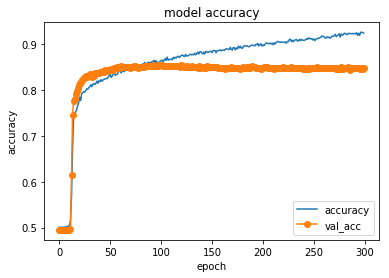

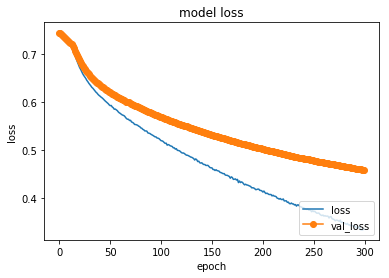

In [5]:
plot_history(history)

In [6]:
model_avg.save_weights('./params.hdf5')

In [7]:
score=model_avg.evaluate(x_test, y_test)

24808/24808 [==============================] - 9s 355us/step


In [8]:
print(score[0],score[1])

0.473302556435 0.838640761045
